Multi-layer Perceptron Regressor (MLPRegressor) - Exercício Bloco 5 TDNN (rede neural com retardo de tempo)
EXERCÍCIO TDNN

Implementar a solução em Python utilizando o Google Colab e responder as questões em forma de relatório. Deve-se apresentar o código em anexo:

O preço de uma determinada mercadoria disposta para ser comercializada no mercado financeiro de ações possui um histórico de variação de valor conforme mostrado na tabela apresentada no Anexo.
Um pool de pesquisadores estará tentando aplicar redes neurais para tentar prever o comportamento futuro deste processo. Assim, pretende-se utilizar uma arquitetura perceptron multicamadas, com topologia “Time Delay” (TDNN), conforme mostrada na figura abaixo:
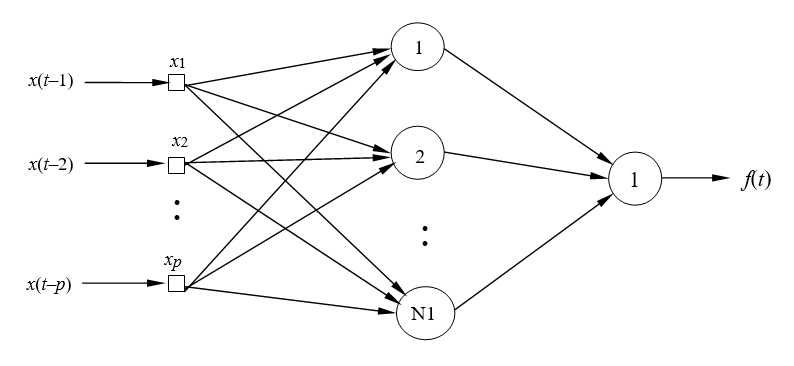

As topologias candidatas para serem adotadas no mapeamento do problema acima são especificadas como se segue:
Rede 1  05 entradas (p = 05) com N1 = 15
Rede 2  10 entradas (p = 10) com N1 = 25
Rede 3  15 entradas (p = 15) com N1 = 50
Utilizando o algoritmo de aprendizagem backpropagation com momentum e os dados de treinamento apresentados no Anexo, realize as seguintes atividades:

1.	Execute 3 treinamentos para cada rede perceptron acima, inicializando-se as matrizes de pesos sinápticos em cada treinamento com valores aleatórios, ou seja, não use o random_state. Utilize a função de ativação e as demais configurações para os testes conforme segue: activation='relu', solver='adam', alpha=0.000001, max_iter=5000, tol=0.000001, momentum=0.9, early_stopping=True, epsilon=1e-06, learning_rate_init = 0.001, learning_rate = 'constant'.

2.	Registre os resultados finais desses 3 treinamentos, considerando-se cada uma dessas três topologias de rede, na tabela a seguir:
Treinamento	Rede 1	Rede 2	Rede 3

3.	Para todos os treinamentos efetuados no item 2, faça então a validação da rede em relação aos valores desejados apresentados na tabela abaixo. Forneça para cada treinamento o Erro Absoluto Médio (MAE) entre os valores desejados e os valores fornecidos pela rede em relação a todas as amostras de teste. Obtenha também o respectivo Erro Quadrático Médio (MSE) e o R2 Score.


4.	Para o melhor treinamento {T1, T2 ou T3} realizado em cada Rede, trace o gráfico de barras dos valores desejados e dos valores estimados pela respectiva rede em função do domínio de operação assumido (t=101..120), ou seja, será necessário plotar 3 gráficos.


In [1]:
from sklearn.model_selection import train_test_split # Biblioteca para separação de amostras para treino e teste, curva de aprendizagem do treinamento e para processar a validação cruzada
from sklearn.neural_network import MLPRegressor # Biblioteca para utilização do Regressor MLP
from sklearn.preprocessing import MinMaxScaler, StandardScaler # Biblioteca utilizada para normalização dos dados
from sklearn.pipeline import Pipeline # Biblioteca para organização de ações em sequência
from sklearn import metrics # Biblioteca para avaliação das métricas no modelo
import matplotlib.pyplot as plt # Para visualizacao dos dados por meio de gráfico
import numpy as np # Biblioteca de manipulação de arrays Numpy
import pandas as pd # Biblioteca para manipulação de dados, aqui especificamente para importação e manipulação inicial do dataset
from google.colab import drive # Biblioteca para interação do colab com o drive
drive.mount('/content/drive') # Montando o Google Drive na mesma conta do Google Colab

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Biblioteca necessaria para a execução do mean
from sklearn.model_selection import GridSearchCV # Biblioteca para a impressão em barras dos 3 resultados

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Carregamento e Organização Inicial do Dataset

In [2]:
# Caminho do dataset no Google Drive que será carregado em df
df = pd.read_csv("/content/drive/MyDrive/DATASET/variacaoValores.csv") # Carregamento do dataset via Pandas
print(df.head(15))

dfNew = pd.DataFrame(columns = ['x-10', 'x-9', 'x-8', 'x-7', 'x-6', 'x-5', 'x-4', 'x-3', 'x-2', 'x-1', 'x']) # Criação de um novo dataframe para reorganizar os dados das amostras baseada no histórico dos 4 últimos preços e o target o próximo

dados = df.iloc[:, 1].values # Dados recebe a segunda coluna
tam = len(dados) # Recebe a quantidade de amostras

for i in range(tam-10): # A subtração de 10 é para não incluir dados vazios nas amostras que serão geradas
  # É criado um novo dataframe que receberá os dados atrasados e o target em x para construção das amostras que serão apresentado no treinamento
  df_new_row = pd.DataFrame({'x-10': [dados[i]], 'x-9': [dados[i+1]], 'x-8': [dados[i+2]], 'x-7': [dados[i+3]],
                             'x-6': [dados[i+4]], 'x-5': [dados[i+5]], 'x-4': [dados[i+6]], 'x-3': [dados[i+7]],
                             'x-2': [dados[i+8]], 'x-1': [dados[i+9]],'x': [dados[i+10]]})
  # A nova amostra é inserida no dataframe final dfNew
  dfNew = pd.concat([dfNew, df_new_row], ignore_index=True)

y = dfNew[['x']] # Inclusão da variável x no vetor de saídas desejadas
x = dfNew.drop('x', axis=1) # Exclusão da variável x das entradas

    Amostra    f(t)
0         1  0.1701
1         2  0.1023
2         3  0.4405
3         4  0.3609
4         5  0.7192
5         6  0.2258
6         7  0.3175
7         8  0.0127
8         9  0.4290
9        10  0.0544
10       11  0.8000
11       12  0.0450
12       13  0.4268
13       14  0.0112
14       15  0.3218


Pré-Processamento dos Dados

In [3]:
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
y = scaler.fit_transform(y)

trainX, testX, trainY, testY = train_test_split(x, y, test_size=0.30, random_state=None) # Separação do dataset em amostras para treino e teste, considerando 30% dos valores para teste
testY = testY.ravel()

# Normalização dos dados
scaler = StandardScaler()
X_train = scaler.fit_transform(trainX)
X_test = scaler.transform(testX)

Aplicação do MLPRegressor

In [4]:
# Execução do treinamento da RNA, no primeiro parâmetro são os dados de entrada e no segundo parâmetro são os dados de saída
# Função para treinar a rede e calcular métricas
def treinar_e_avaliar_rede(X_train, X_test, y_train, y_test, hidden_layers):
    resultados = []
    for i in range(3):  # 3 treinamentos para cada configuração
        mlp = MLPRegressor(hidden_layer_sizes=hidden_layers, activation='relu', solver='adam', alpha=1e-6,
                           max_iter=5000, tol=1e-6, momentum=0.9, early_stopping=True, epsilon=1e-06,
                           learning_rate_init=0.001, learning_rate='constant')
        mlp.fit(X_train, y_train)
        predictions = mlp.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        resultados.append({'MAE': mae, 'MSE': mse, 'R2': r2, 'Predictions': predictions, 'Model': mlp})
    return resultados

# Especificando topologias das redes
topologias = [(10,), (10,5,), (10,5,2)]
resultados = {}

for topo in topologias:
    resultados[str(topo)] = treinar_e_avaliar_rede(trainX, testX, trainY, testY, topo)


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1623: DataConversionWarning: A column-vector y was passed w

Avaliação do Modelo

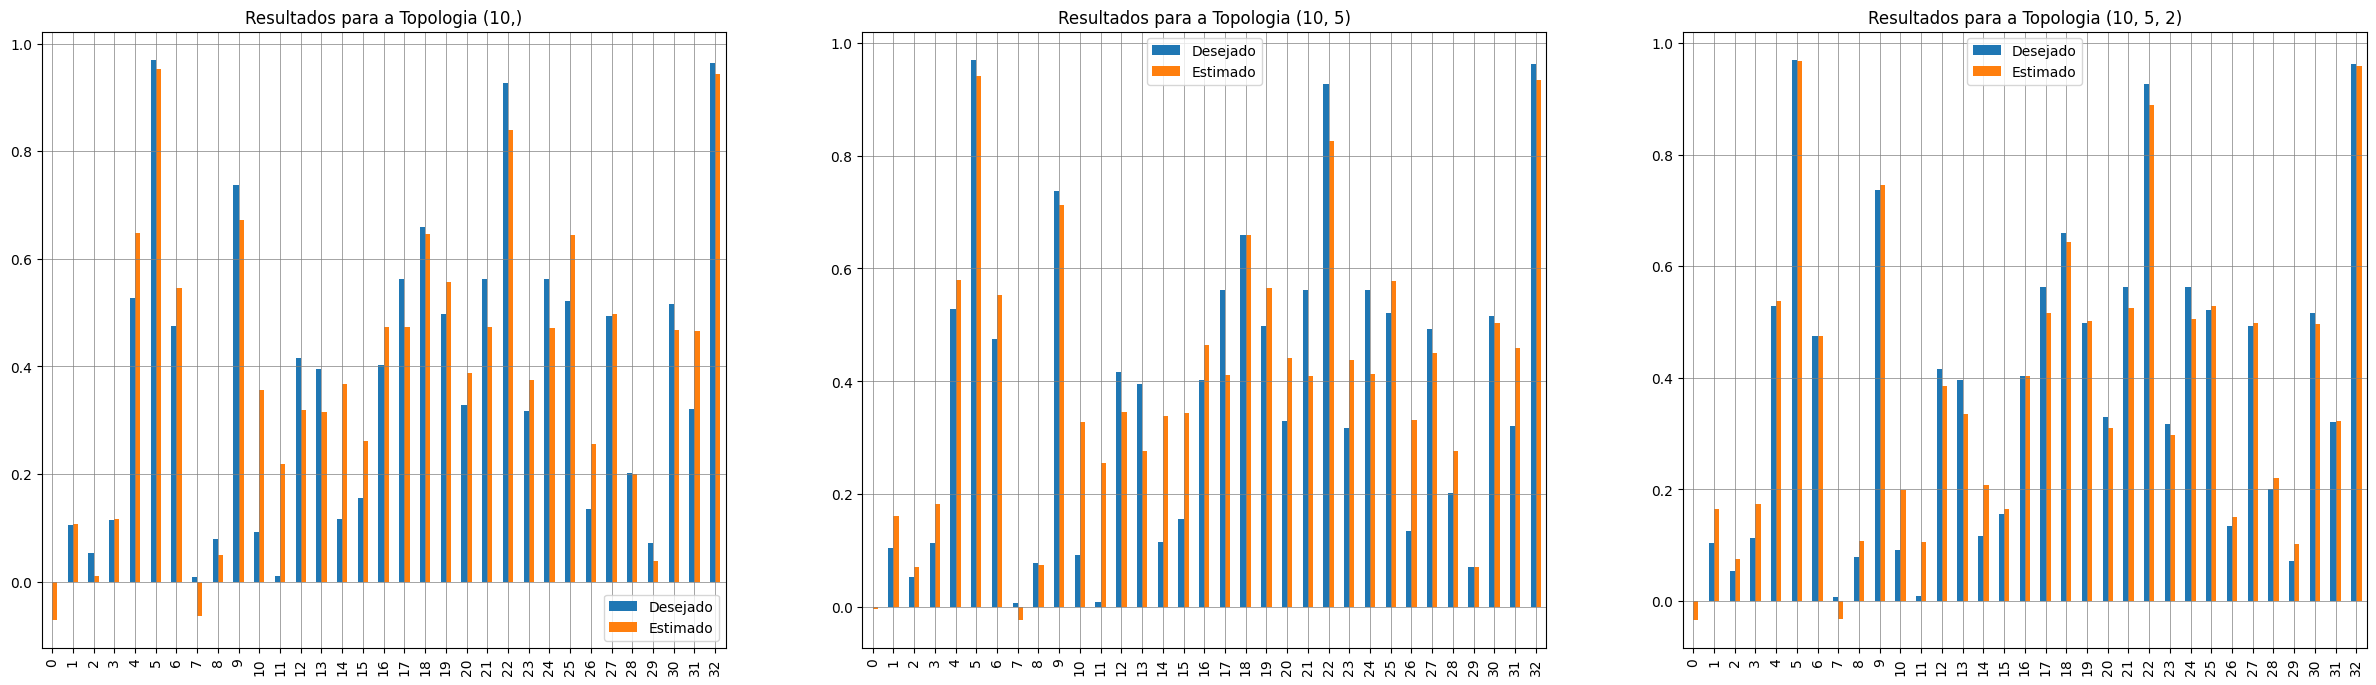

In [9]:
# Exibindo gráfica das 3 topologias
plt.figure(figsize=(30, 8))  # Ajuste o tamanho conforme necessário

# Iterando sobre os resultados para gerar cada subplot
for i, (topo, resultado) in enumerate(resultados.items(), start=1):
    melhor_resultado = min(resultado, key=lambda x: x['MSE'])  # Selecionando o melhor resultado baseado no MSE
    y_pred = melhor_resultado['Predictions']

    df_temp = pd.DataFrame({'Desejado': testY, 'Estimado': y_pred})  # Usando testY como 'Desejado'
    df_temp = df_temp.head(60)  # Limitando a quantidade de elementos para o gráfico

    # Criando um subplot para cada resultado
    plt.subplot(1, len(resultados), i)  # 1 linha, N colunas, índice do subplot atual
    df_temp.plot(kind='bar', ax=plt.gca())  # plt.gca() obtém o conjunto atual de eixos para o plot
    plt.title(f'Resultados para a Topologia {topo}')
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='gray')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='blue')

# Mostrando a figura com todos os subplots
plt.show()

Avaliação do Erro no Processo de Treinamento

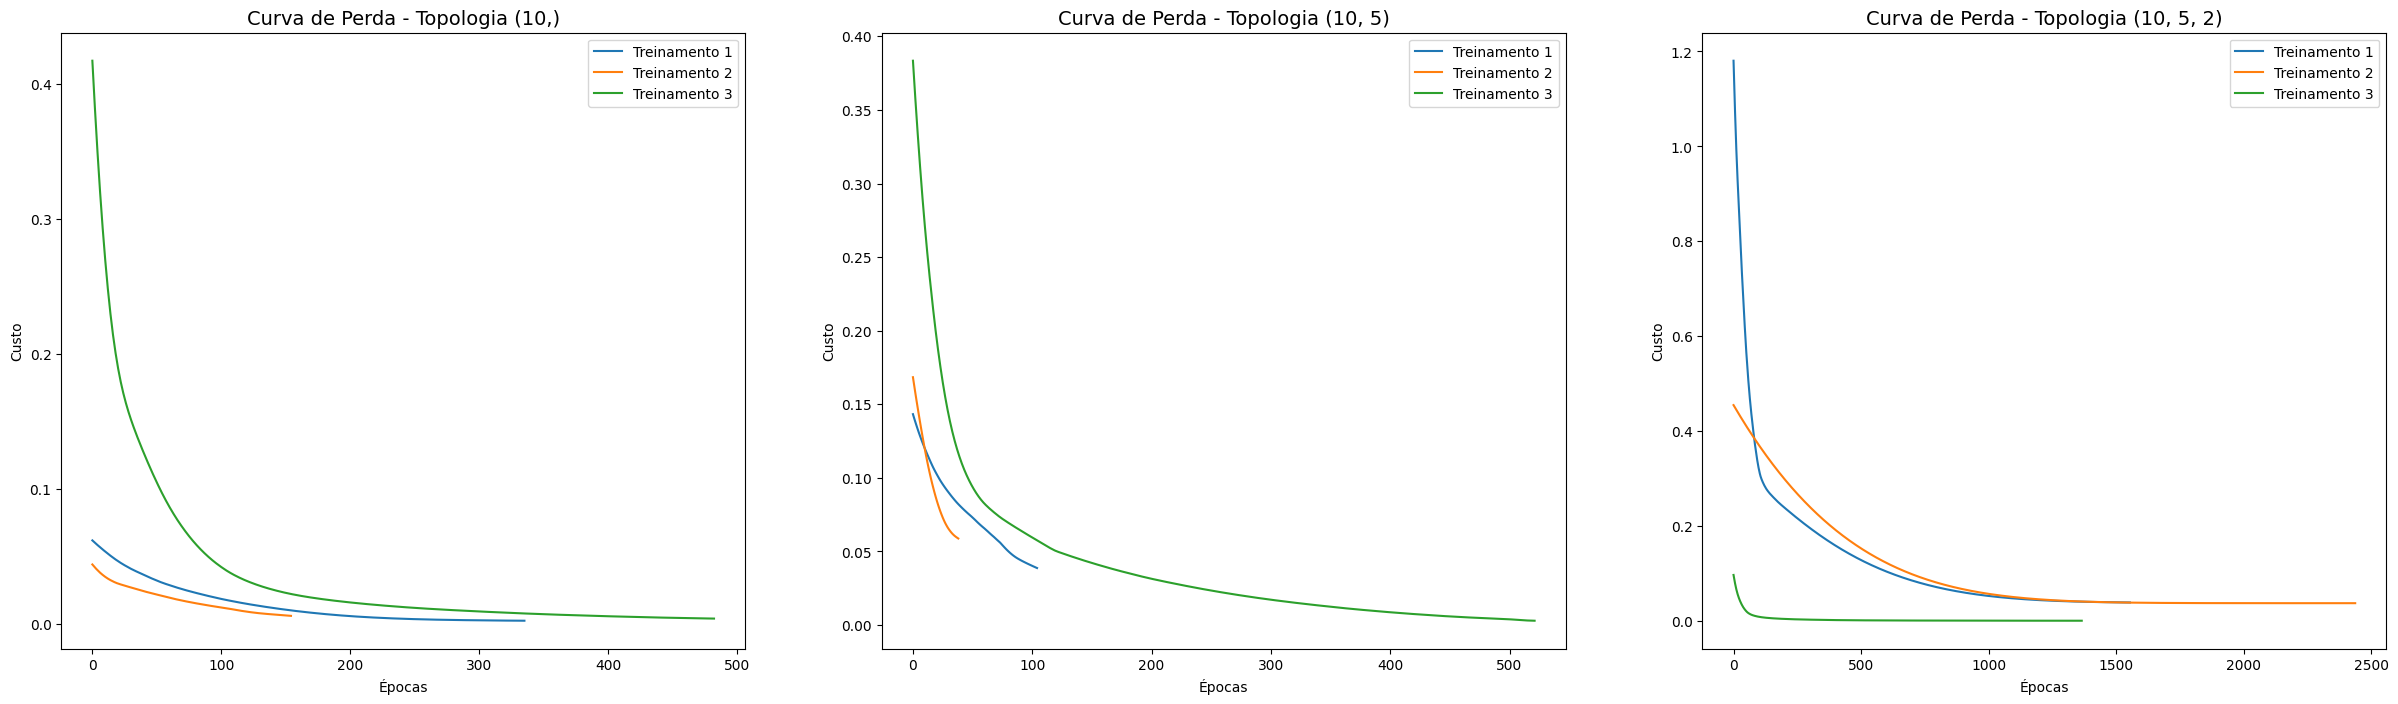

In [10]:
# Plotando a curva de perda das 3 topologias
plt.figure(figsize=(30, 8))  # Ajuste o tamanho conforme necessário

# Iterando sobre os resultados para gerar cada subplot
for i, (topo, resultado) in enumerate(resultados.items(), start=1):
    # Criando um subplot para cada topologia
    plt.subplot(1, len(resultados), i)  # 1 linha, N colunas, índice do subplot atual

    # Plotando a curva de perda para cada treinamento da topologia
    for j, r in enumerate(resultado, 1):
        mlp_reg = r['Model']
        plt.plot(mlp_reg.loss_curve_, label=f'Treinamento {j}')

    plt.title(f"Curva de Perda - Topologia {topo}", fontsize=14)
    plt.xlabel('Épocas')
    plt.ylabel('Custo')
    plt.legend()

# Mostrando a figura com todos os subplots
plt.show()

Resumo das Métricas
Links de Referência:
- https://michael-fuchs-python.netlify.app/2019/06/30/metrics-for-regression-analysis/
- https://medium.com/turing-talks/como-avaliar-seu-modelo-de-regress%C3%A3o-c2c8d73dab96

In [7]:
for topo, resultado in resultados.items():
    # Selecionando o melhor resultado para a topologia baseado no MSE
    melhor_resultado = min(resultado, key=lambda x: x['MSE'])

    # Acessando o modelo do melhor resultado
    mlp_reg = melhor_resultado['Model']
    y_pred = melhor_resultado['Predictions']

    # Exibindo métricas para o melhor treinamento da topologia atual
    print(f"Resultados para a Topologia {topo}:")
    print('Epochs: ', mlp_reg.n_iter_)
    print('Loss: ', mlp_reg.loss_)
    print('Mean Absolute Error (MAE): ', metrics.mean_absolute_error(testY, y_pred))
    print('Mean Squared Error (MSE): ', metrics.mean_squared_error(testY, y_pred))
    print('Root Mean Squared Error (RMSE): ', metrics.mean_squared_error(testY, y_pred, squared=False))
    print('R2 Score: ', metrics.r2_score(testY, y_pred))
    print('='*80)

Resultados para a Topologia (10,):
Epochs:  336
Loss:  0.0025084426754523087
Mean Absolute Error (MAE):  0.07916921065488193
Mean Squared Error (MSE):  0.01036930061876373
Root Mean Squared Error (RMSE):  0.10182976293188416
R2 Score:  0.8661103533752041
Resultados para a Topologia (10, 5):
Epochs:  522
Loss:  0.002897272791630063
Mean Absolute Error (MAE):  0.08849959381769466
Mean Squared Error (MSE):  0.012865707729403472
Root Mean Squared Error (RMSE):  0.11342710315177529
R2 Score:  0.8338764469466109
Resultados para a Topologia (10, 5, 2):
Epochs:  1366
Loss:  0.00035138948311670026
Mean Absolute Error (MAE):  0.030516410285116615
Mean Squared Error (MSE):  0.0017135833543744452
Root Mean Squared Error (RMSE):  0.04139545088985558
R2 Score:  0.9778740073014991


Sintonizador dos melhores Hiperparâmetros

Configuração: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'max_iter': 2000, 'solver': 'lbfgs'}
MAE: 0.004545453798476195
MSE: 4.4196074673875334e-05
RMSE: 0.0066480128364704094
R2 Score: 0.999429335011314


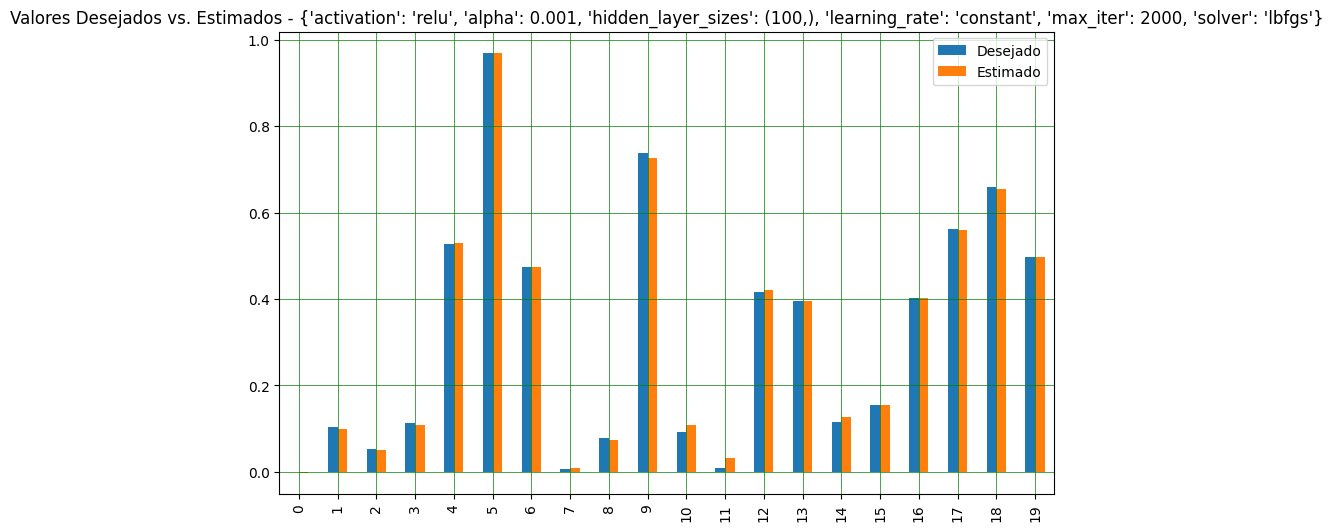

Configuração: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'max_iter': 2000, 'solver': 'lbfgs'}
MAE: 0.003628344285344233
MSE: 3.5339790961325206e-05
RMSE: 0.005944727997253129
R2 Score: 0.9995436884031461


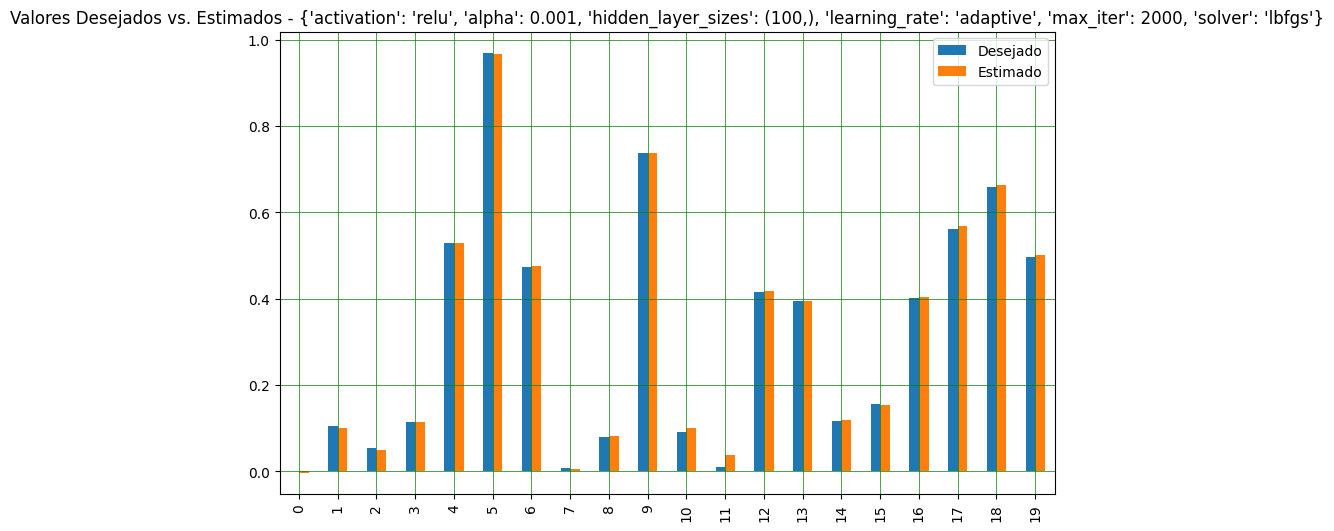

Configuração: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'max_iter': 5000, 'solver': 'lbfgs'}
MAE: 0.00552920463849835
MSE: 6.302970022266613e-05
RMSE: 0.007939124650908696
R2 Score: 0.9991861529914169


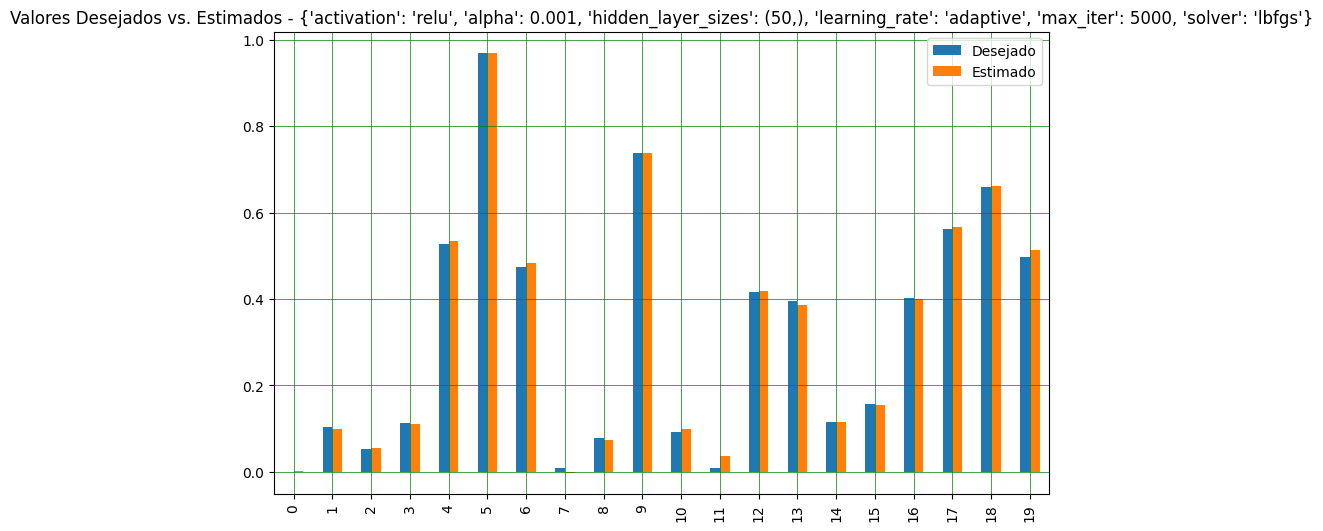

In [8]:
# Configuração do MLPRegressor e GridSearchCV
mlp_reg = MLPRegressor()
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'max_iter': [2000, 5000],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.01, 0.001],
    'learning_rate': ['constant', 'adaptive'],
}

grid = GridSearchCV(mlp_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid.fit(x, y.ravel())

# Ordenando os resultados e selecionando os três melhores conjuntos
results = pd.DataFrame(grid.cv_results_)
best_three = results.sort_values(by='rank_test_score').head(3)

for index, row in best_three.iterrows():
    # Configurando o regressor com os parâmetros
    best_mlp_reg = MLPRegressor(**row['params'])
    best_mlp_reg.fit(x, y.ravel())  # Treinar com todo o conjunto de treinamento
    predictions = best_mlp_reg.predict(testX)

    # Exibindo as métricas
    print(f"Configuração: {row['params']}")
    print(f"MAE: {mean_absolute_error(testY, predictions)}")
    print(f"MSE: {mean_squared_error(testY, predictions)}")
    print(f"RMSE: {mean_squared_error(testY, predictions, squared=False)}")
    print(f"R2 Score: {r2_score(testY, predictions)}")
    print('='*80)

    # Dados para o gráfico
    df_temp2 = pd.DataFrame({'Desejado': testY, 'Estimado': predictions})
    df_temp2 = df_temp2.head(20)  # Ajustando para os primeiros 20 exemplos
    df_temp2.plot(kind='bar', figsize=(10,6))
    plt.title(f"Valores Desejados vs. Estimados - {row['params']}")
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()